# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).
 
 
Here we'll take cropped images of antinodes and try to count the rings, by fashioning a regression model out of a one-class classification model and scaling the output sigmoid (via fastai's y_range parameter) so that our fitted values stay within the linear regime of the sigmoid.

And we also want to "clamp" our output between a min of about 0.2 rings and a max of 11 rings, because that's how the dataset was created; so sigmoid makes a good choice for this "clamping" too.

In [ ]:
#all_slow

## Installs & Imports

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
import espiownage
from espiownage.core import *
sysinfo()
print(f"espiownage version {espiownage.__version__}")

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu102
CUDA available = True, Device count = 1, Current device = 0
Device name = NVIDIA GeForce RTX 2070 with Max-Q Design
hostname: oryxpro
espiownage version 0.0.47


And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

# Run parameters

In [ ]:
dataset_name = 'preclean' # choose from: 
                            # - cleaner (*real* data that's clean-er than "preclean"), 
                            # - preclean (unedited aggregates of 15-or-more volunteers)
                            # - spnet,   (original SPNet Real dataset)
                            # - cyclegan (original SPNet CGSmall dataset)
                            # - fake (newer than SPNet fake, this includes non-int ring #s)
use_wandb = False        # WandB.ai logging
project = 'count_in_crops' # project name for wandb

In [ ]:
# Optional: WandB tracking
if use_wandb: 
    !pip install wandb -qqq
    import wandb
    from fastai.callback.wandb import *
    from fastai.callback.tracker import SaveModelCallback
    wandb.login()

In [ ]:
# Download / locate data 
path = get_data(dataset_name) / 'crops'; path

Path('/home/sstudent/.espiownage/data/espiownage-preclean/crops')

In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

3687 total cropped images


Path('/home/sstudent/.espiownage/data/espiownage-preclean/crops/06241902_proc_01101_138_72_289_221_7.33.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

7.33


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=label_func,
                    item_tfms=Resize(cropsize, ResizeMethod.Squish),
                    batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), 
                    Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

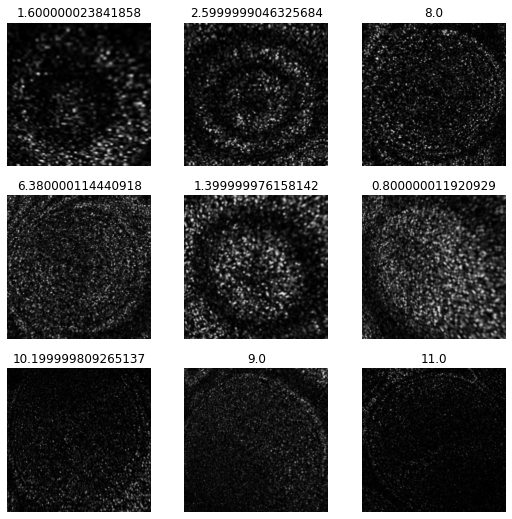

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
opt = ranger

In [ ]:
y_range=(0.2,13)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, metrics=[mae, acc_reg05,acc_reg1,acc_reg15,acc_reg2], loss_func=MSELossFlat(), opt_func=opt)

/home/sstudent/envs/espi/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.015848932787775993)

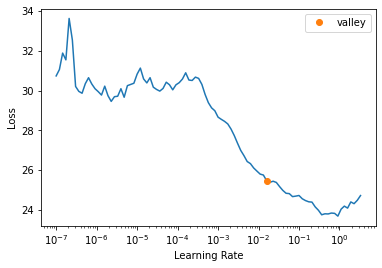

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
lr = 5e-3
learn.fine_tune(30, lr, freeze_epochs=2)  # accidentally ran this twice in a row :-O

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,17.673943,11.602392,2.633210,0.130258,0.268657,0.397558,0.512890,00:21
1,14.108625,10.193328,2.579160,0.063772,0.181818,0.371777,0.499322,00:21


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,11.066119,5.478100,1.805679,0.164179,0.331072,0.535957,0.667571,00:28
1,9.819327,4.119735,1.618032,0.180461,0.375848,0.557666,0.693351,00:28
2,8.218352,3.253291,1.421669,0.208955,0.417910,0.629579,0.763908,00:28
3,6.109016,2.747886,1.263055,0.309362,0.514247,0.659430,0.762551,00:28
4,4.424803,3.013605,1.306242,0.280868,0.506106,0.666214,0.767978,00:28
5,3.551521,2.053637,1.073591,0.318860,0.597015,0.738128,0.849389,00:28
6,3.088981,2.078550,1.119599,0.295794,0.544098,0.740841,0.841248,00:28
7,2.950196,2.554464,1.209759,0.252375,0.531886,0.701493,0.811398,00:28
8,2.715012,2.051887,1.072478,0.328358,0.602442,0.742198,0.842605,00:28
9,2.612765,1.970868,1.024343,0.370421,0.624152,0.767978,0.849389,00:28


In [ ]:
learn.save(f'crop-rings-{dataset_name}')

Path('models/crop-rings-preclean.pth')

## Interpretation

In [ ]:
learn.load(f'crop-rings-{dataset_name}');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

737

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {os.path.basename(dls.valid.items[ind])}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([7.2803]), targs[0] = 9.25, loss = 3.879777669906616
file = 06240907_proc_01364_0_107_173_324_9.25.png
Image:


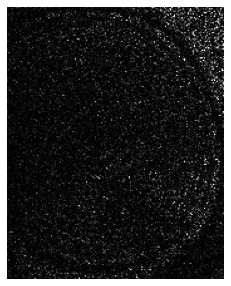

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
736,06240907_proc_00877_0_101_188_316_2.0,2.00,7.82,33.921112,736
104,06240907_proc_00742_0_101_212_336_2.33,2.33,6.97,21.56799,104
237,06241902_proc_01283_142_75_291_218_2.0,2.00,6.50,20.252584,237
481,06240907_proc_00936_205_92_372_299_3.0,3.00,7.07,16.529354,481
656,06241902_proc_01176_151_78_278_213_1.67,1.67,5.68,16.079632,656


preds[736] = tensor([7.8242]), targs[736] = 2.0, loss = 33.921112060546875
file = 06240907_proc_00877_0_101_188_316_2.0.png
Image:
preds[104] = tensor([6.9741]), targs[104] = 2.3299999237060547, loss = 21.567989349365234
file = 06240907_proc_00742_0_101_212_336_2.33.png
Image:
preds[237] = tensor([6.5003]), targs[237] = 2.0, loss = 20.25258445739746
file = 06241902_proc_01283_142_75_291_218_2.0.png
Image:
preds[481] = tensor([7.0656]), targs[481] = 3.0, loss = 16.529354095458984
file = 06240907_proc_00936_205_92_372_299_3.0.png
Image:
preds[656] = tensor([5.6799]), targs[656] = 1.6699999570846558, loss = 16.079631805419922
file = 06241902_proc_01176_151_78_278_213_1.67.png
Image:


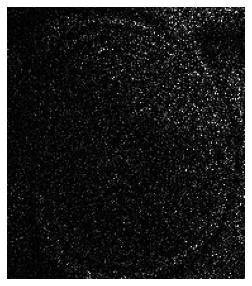

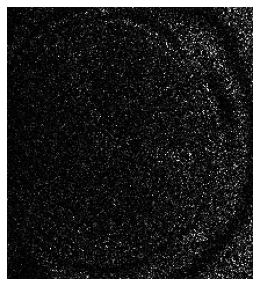

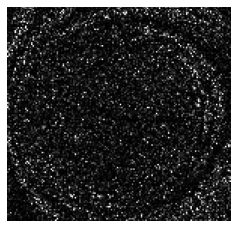

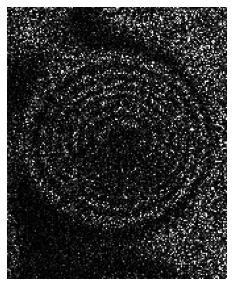

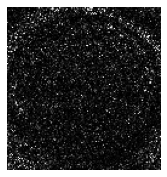

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv(f'ring_count_top_losses_{dataset_name}.csv', index=False)

## When in doubt, look at the data...
Let's take a look at plots of this data

In [ ]:
df2 = res_df.reset_index(drop=True)

Text(0, 0.5, 'Ring count')

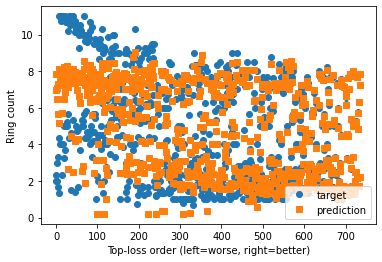

In [ ]:
plt.plot(df2["target"],'o',label='target')
plt.plot(df2["prediction"],'s', label='prediction')
plt.xlabel('Top-loss order (left=worse, right=better)')
plt.legend(loc='lower right')
plt.ylabel('Ring count')

(0.15349999999999997, 11.5165, -0.24350000000000005, 11.119500000000002)

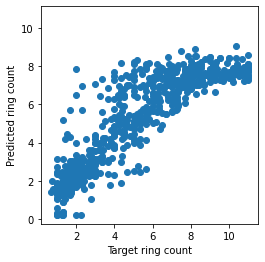

In [ ]:
plt.plot(df2["target"],df2["prediction"],'o')
plt.xlabel('Target ring count')
plt.ylabel('Predicted ring count')
plt.axis('square')

In [ ]:
print(f"Target ring count range: ({df2['target'].min()}, {df2['target'].max()})")
print(f"Predicted ring count range: ({df2['prediction'].min()}, {df2['prediction'].max()})")

Target ring count range: (0.67, 11.0)
Predicted ring count range: (0.2, 9.07)
